# 1. Goals
In this notebook I'll attempt to build models to correctly predict the topic of the article. The techniques I'll use will include `Tf-idf` and `BOW` Analysis for feature-extraction, and `Unsupervised Learning` (Sklearn library) for clustering.

# 2. Introduction to DataSet
**From:** [snapcrack/all-the-news](https://www.kaggle.com/snapcrack/all-the-news)

This dataset contains news articles scraped from various publications, labeled by publication and author name, as well as date and title.
The original source on [kaggle.com](https://www.kaggle.com) contains three `.csv` files. Accross the three, there are over 140,000 articles from a total of 15 publications.

# Step: Import libraries

In [1]:
# --------- Data processing --------- #
import pandas as pd
import numpy as np
from collections import Counter
# --------- Gensim --------- #
import gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaMulticore, CoherenceModel
from gensim.models.wrappers import LdaMallet
# --------- Visualization --------- #
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from wordcloud import WordCloud
import plotly.express as px

# Step: Extract & show data

In [2]:
"""
Function for extract useful column from datasets.
If choice is Ture you can shuffle 10_000 from each dataset
"""
def create_dataframe(directory: list, columns: str, choice: bool = False) -> pd.Series:
    dataframes = []
    for file in directory:
        dataframe = pd.read_csv(file)
        dataframe = dataframe[columns]
        if choice:
            choices = np.random.choice(range(49999), 10000, replace=False)
            dataframe = dataframe[choices]
        dataframes.append(dataframe)
    corpus_series = pd.concat(dataframes, ignore_index=True)
    return corpus_series

# List of path of datasets
directory = [
    'data/articles1.csv',
    'data/articles2.csv',
]
df = create_dataframe(directory, 'content')

In [3]:
df.describe()

count             99999
unique            99488
top       advertisement
freq                 42
Name: content, dtype: object

In [4]:
print('number of nan value: ', df.isna().sum())

number of nan value:  0


In [5]:
print('Head of data:\n',df.head())
print('\nTail of data:\n',df.tail())

Head of data:
 0    WASHINGTON  —   Congressional Republicans have...
1    After the bullet shells get counted, the blood...
2    When Walt Disney’s “Bambi” opened in 1942, cri...
3    Death may be the great equalizer, but it isn’t...
4    SEOUL, South Korea  —   North Korea’s leader, ...
Name: content, dtype: object

Tail of data:
 99994    There have been many proposed solutions to the...
99995    Maybe I feel like August won’t let go of me, b...
99996    Diana Marcela, 28, has spent 13 years with Far...
99997    This Christmas break, for anybody steeped in t...
99998    Brian Nesbitt’s therapist made a suggestion in...
Name: content, dtype: object


# Step: pre-process data

I use various libraries to perform this cleaning

- Remove extra items from the text (e.g mail address, numbers, whitespace)
- Tokenize text (Each text a list and each word a index of this list)
- Make bigram words (A word for two words that are often repeated)


In [24]:
def simple_preprocess(row: str) -> list:
    import re
    from textblob import Word
    from string import punctuation
    from nltk import word_tokenize
    from nltk.stem.snowball import SnowballStemmer
    from gensim.parsing.preprocessing import STOPWORDS
    
    
    publication = {'breitbart','cnn','talking','points','guardian','york',
                   'national','new','business','fox','review','insider',
                   'memo','times','buzzfeed', 'post', 'news', 'atlantic'}
    STOPWORDS = STOPWORDS | publication
    #Mail address
    row = re.sub('(\S+@\S+)(com|\s+com)', ' ', row)
    #Username
    row = re.sub('(\S+@\S+)', ' ', row)
    #punctuation and lowercase
    punctuation = punctuation + '\n' + '—“,”‘-’' + '0123456789'
    row = ''.join(word.lower() for word in row if word not in punctuation)
    #Extra whitespace
    row = re.sub('\s{1,}', ' ', row)
    #tokenize
    row = word_tokenize(row)
    #Stopwords and Lemma
    row = [Word(word).lemmatize() for word in row if word not in STOPWORDS]
    #Stemming
    #stemmer = SnowballStemmer(language='english')
    #row = [stemmer.stem(word) for word in row]
    row = [word for word in row if len(word) > 2]
    '''
    a good approach for good topic modeling is
    extract useful part of speech in my preprocessing
    without any show part of speech, only good words remain :)
    so if need to part od speech nltk.pos_tag is a good and simple package
    '''
    return row

def make_bigram(data: list) -> list:
    from gensim.models import Phrases
    from gensim.models.phrases import Phraser

    bigram = Phrases(data, min_count=8, threshold=20)
    bigram_mod = Phraser(bigram)

    sequences = [bigram_mod[row] for row in data]
    return sequences

In [7]:
%%time
data = df.values.tolist()
sentences = [simple_preprocess(row) for row in data]
sentences = make_bigram(sentences)

Wall time: 42min 27s


In [8]:
print('cleaned text:\n', sentences[12][0:60])

cleaned text:
 ['west_palm', 'beach_fla', 'donald_trump', 'year', 'weekend', 'opulence', 'actor', 'sylvester_stallone', 'gossip', 'page', 'fixture', 'fabio', 'crowd', 'wealthy', 'developer', 'palm_tree', 'trump', 'resort_palm', 'beach', 'president', 'george_bush', 'ranch_crawford', 'compound', 'kennebunkport', 'president', 'frequent', 'vacation_hawaii', 'private', 'home', 'trump', 'private', 'club', 'florida', 'week', 'home', 'city', 'likely', 'eclipse', 'president', 'winter', 'white_house', 'intention', 'cereal', 'heiress', 'property', 'original', 'owner', 'federal_government', 'serve', 'home', 'president', 'government', 'plan', 'property', 'club_membership', 'cost', 'figure', 'trump', 'arrival', 'sneer']


In [9]:
dictionary = Dictionary(documents=sentences)

In [10]:
# add all of cleared text in a Series for easy save (.csv)
series = pd.Series(dtype='object')
for row in sentences:
    series = series.append(pd.Series(', '.join(row)))

In [11]:
# store the dictionary and pre-processed, for future reference
series.to_csv('data/NOUN-ADJ.csv', index=False)
dictionary.save('data/NOUN-ADJ.dict')

In [2]:
# Load pre-processed words
data = pd.read_csv('data/NOUN-ADJ.csv', header=0, names=['clean_content'])
data = data['clean_content']
data.dropna(inplace=True)
sentences = [row.split(', ') for row in data]

In [5]:
def frequency(data: pd.Series, most: int) -> Counter:
    frequency = []
    for row in data:
        for word in row:
            frequency.append(word)
    frequency = Counter(frequency).most_common(most)
    return frequency

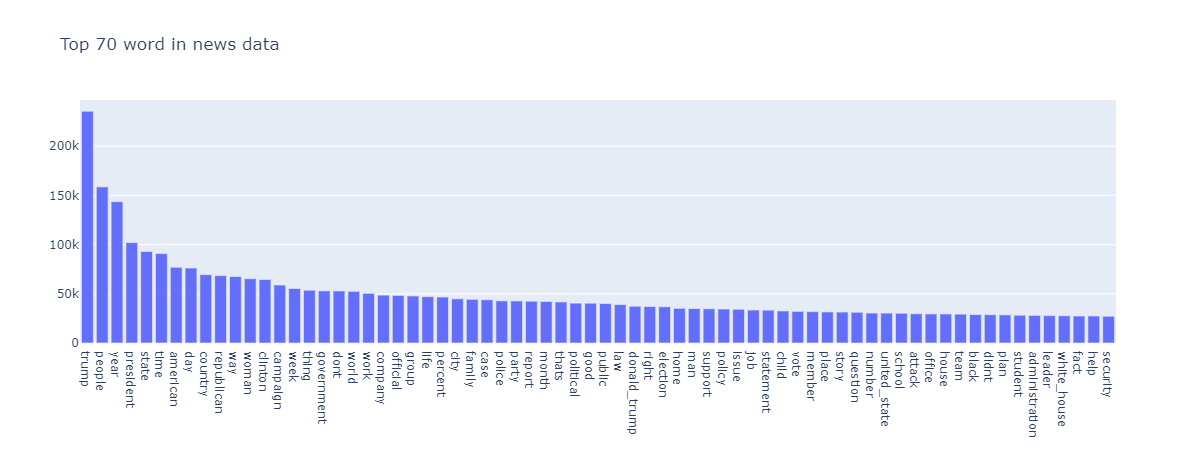

In [8]:
word_freq = frequency(sentences, 70)

X_fig = [word[0] for word in word_freq]
y_fig = [freq[1] for freq in word_freq]
fig = go.Figure([go.Bar(x=X_fig, y=y_fig)])
fig.update_layout(title_text='Top 70 word in news data')
fig.show()

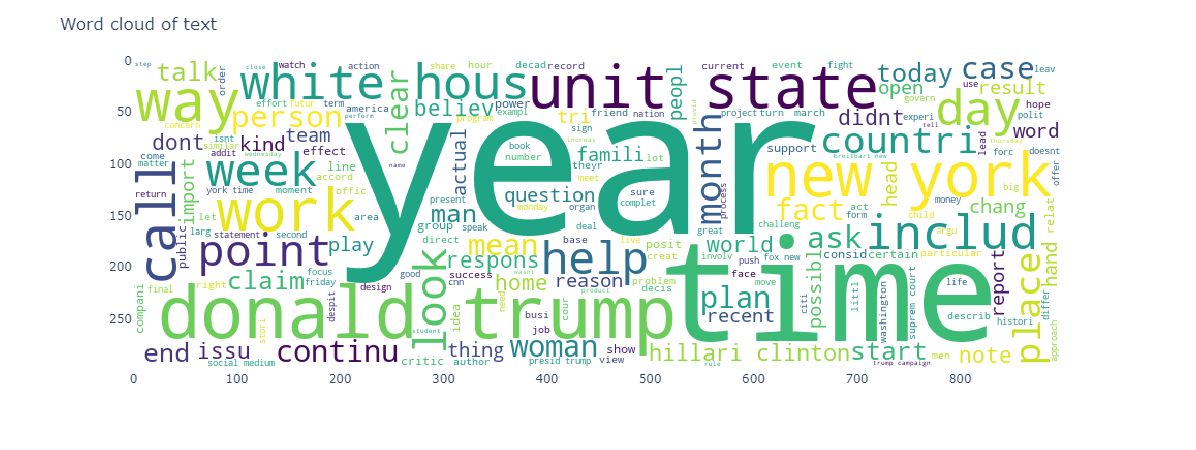

In [9]:
text = [' '.join(row) for row in sentences]
text = ' '.join(text)

wordclud = WordCloud(width=900, height=300, background_color='white').generate(text)
fig = px.imshow(wordclud)
fig.update_layout(title_text='Word cloud of text')
fig.show()

In [3]:
# Load dictionary
dictionary = Dictionary.load('data/NOUN-ADJ.dict')
# Checking dictionary loaded
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 access
1 act
2 administration
3 advocate
4 affordable_care
5 ally
6 american
7 annual_appropriation
8 appeal
9 approval
10 aspect


In [4]:
print('len dictionary before filtering: ',len(dictionary.token2id))
'''
- words appearing less than 10 times
- words appearing in more than 30% of all documents
- keep 120_000 words most frequent 
'''
dictionary.filter_extremes(no_below=10, no_above=0.30, keep_n=120_000)

print('len dictionary after filtering: ',len(dictionary.token2id))

len dictionary before filtering:  252734
len dictionary after filtering:  64001


# Step: feature extraction

for topic modeling we use 2 feature-extraction `Tf-idf` and `Bag-of-word` after this work, see result and choice best method 

In [5]:
# Create the Bag-of-words model for each document
bow_corpus = [dictionary.doc2bow(doc) for doc in sentences]

# Create tf-idf model for each document
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

In [6]:
# Preview BOW, tf-idf for our sample preprocessed document
document_n = 80
bow_doc_x = bow_corpus[document_n]
tfidf_doc_x = tfidf_corpus[document_n]
for i in range(20):
    print(f'Word {bow_doc_x[i][0]} "{dictionary[bow_doc_x[i][0]]}" appears {bow_doc_x[i][1]} time. with {tfidf_doc_x[i][1]:.5f} frequency')

Word 20 "cause" appears 1 time. with 0.01606 frequency
Word 85 "important" appears 1 time. with 0.01220 frequency
Word 96 "judge" appears 1 time. with 0.01691 frequency
Word 119 "official" appears 1 time. with 0.00930 frequency
Word 127 "political" appears 1 time. with 0.00988 frequency
Word 129 "potential" appears 1 time. with 0.01523 frequency
Word 172 "united_state" appears 1 time. with 0.01140 frequency
Word 174 "view" appears 1 time. with 0.01365 frequency
Word 196 "analysis" appears 1 time. with 0.02104 frequency
Word 222 "black" appears 1 time. with 0.01413 frequency
Word 270 "channel" appears 1 time. with 0.02204 frequency
Word 273 "chief" appears 1 time. with 0.01560 frequency
Word 274 "child" appears 1 time. with 0.01224 frequency
Word 284 "close" appears 2 time. with 0.03128 frequency
Word 322 "criminal" appears 1 time. with 0.01841 frequency
Word 337 "death" appears 1 time. with 0.01366 frequency
Word 386 "evidence" appears 1 time. with 0.01489 frequency
Word 464 "high" app

# Step: Create model
## Latent Dirichlet Allocation

LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

* Reference: http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

In [7]:
%%time
# Train your lda model 9 topic bag-of-word
lda_model_b9 = LdaMulticore(corpus = bow_corpus, num_topics = 9,
                            id2word = dictionary, workers=3,
                            chunksize = 1000,
                            passes = 10,
                            iterations = 100,
                            per_word_topics=True,
                           )

Wall time: 11min 5s


In [9]:
%%time
# Train your lda model 9 topic tf-idf
lda_model_t9 = LdaMulticore(corpus = tfidf_corpus, num_topics = 9,
                            id2word = dictionary, workers=3,
                            chunksize = 1000,
                            passes = 10,
                            iterations = 100,
                            per_word_topics=True,
                           )

Wall time: 24min 43s


In [11]:
# save created model
lda_model_b9.save('data/model_b9', ignore=('state', 'dispatcher'))
lda_model_t9.save('data/model_t9', ignore=('state', 'dispatcher'))

# visualisation
after we build LDA model, need to visualize this for show better result. 
the easiest approch is to use `pyLDAvis` package, with less than a few line code we have a good visualisation.

In [7]:
def visualisation(lda, corpus, dictionary):
    import pyLDAvis
    from pyLDAvis.gensim import prepare
    vis = prepare(lda, corpus, dictionary)
    return pyLDAvis.show(vis)

In [8]:
coherence_model_lda_b9 = CoherenceModel(model=lda_model_b9,
                                        texts=sentences,
                                        dictionary=dictionary,
                                        coherence='c_v')
coherence_lda_b9 = coherence_model_lda_b9.get_coherence()
print('\nCoherence Score: ', coherence_lda_b9)


Coherence Score:  0.5413118782426568


In [10]:
coherence_model_lda_t9 = CoherenceModel(model=lda_model_t9,
                                        texts=sentences,
                                        dictionary=dictionary,
                                        coherence='c_v')
coherence_lda_t9 = coherence_model_lda_t9.get_coherence()
print('\nCoherence Score: ', coherence_lda_t9)


Coherence Score:  0.5462836662403908


# WTF ?
tf-idf and bag of word with out any good difference !!!
ok go to see topics

In [12]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for bow_model, tfidf_model in zip(lda_model_b9.print_topics(-1, 7), lda_model_t9.print_topics(-1, 7)):
    print('Topic: ', bow_model[0], tfidf_model[0])
    print('Tfidf Words: ', tfidf_model[1])
    print('Bow Words: ', bow_model[1])
    print('+++++++')

Topic:  0 0
Tfidf Words:  0.005*"clinton" + 0.004*"republican" + 0.003*"campaign" + 0.002*"party" + 0.002*"election" + 0.002*"donald_trump" + 0.002*"vote"
Bow Words:  0.010*"world" + 0.007*"china" + 0.007*"government" + 0.006*"russia" + 0.006*"war" + 0.005*"leader" + 0.005*"power"
+++++++
Topic:  1 1
Tfidf Words:  0.011*"tesla" + 0.008*"gawker" + 0.006*"cosby" + 0.006*"musk" + 0.005*"hogan" + 0.005*"thiel" + 0.004*"denton"
Bow Words:  0.015*"game" + 0.011*"team" + 0.010*"season" + 0.008*"player" + 0.008*"film" + 0.006*"play" + 0.005*"movie"
+++++++
Topic:  2 2
Tfidf Words:  0.008*"knicks" + 0.006*"food" + 0.006*"airline" + 0.006*"flight" + 0.006*"square_foot" + 0.004*"plane" + 0.004*"cuba"
Bow Words:  0.010*"official" + 0.009*"investigation" + 0.008*"white_house" + 0.008*"report" + 0.008*"case" + 0.008*"court" + 0.007*"information"
+++++++
Topic:  3 3
Tfidf Words:  0.010*"court" + 0.006*"supreme_court" + 0.006*"executive_order" + 0.006*"judge" + 0.006*"immigration" + 0.005*"law" + 0.00

it seem bag-of-word a little better than tf-idf thus:
- [ ] Tf-idf
- [x] Bag-of-word 

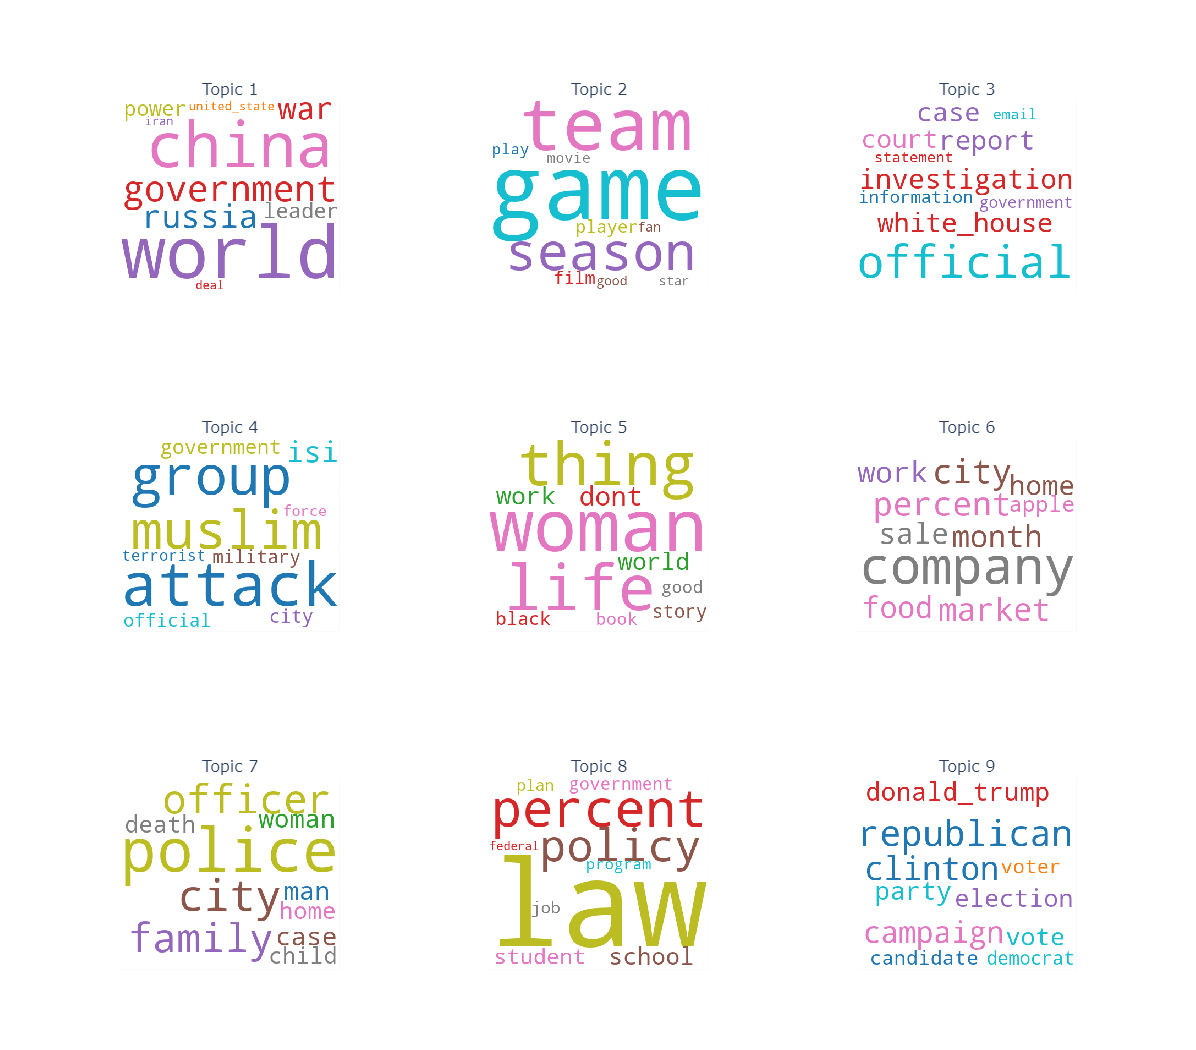

In [13]:
topics = lda_model_b9.show_topics(num_words=10, formatted=False)

cloud = WordCloud(background_color='white',
                  width=400,
                  height=350,
                  max_words=20,
                  colormap='tab10',
                  prefer_horizontal=1.0)

fig = make_subplots(3, 3,
                    subplot_titles=tuple(f'Topic {n+1}' for n in range(9)))
for n in range(9):
    topic_words = dict(topics[n][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    fig.add_trace(px.imshow(cloud).data[0],
                  row=int(n/3)+1, col=n%3+1)

fig.update_layout(height=1050, width=1200, coloraxis_showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

- topics:
    1. U.S
    2. World
    3. Health

In [6]:
import os
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'
ldamallet = LdaMallet(mallet_path,
                      corpus=bow_corpus,
                      workers=3,
                      num_topics=9,
                      iterations=100
                      id2word=dictionary)

In [9]:
coherence_model_mallet = CoherenceModel(model=ldamallet,
                                        texts=sentences,
                                        corpus=bow_corpus,
                                        dictionary=dictionary,)
print('Coherence Score: ', coherence_model_mallet.get_coherence())

Coherence Score:  0.528899342179122
